# Introduction

Now that we have done some analysis of the stock prices, let's try to forecast some data. The forecasting we're going to do is univariate, and we will try 2 forecasting approaches: i) Statitical approach using ARMA ; ii) Deep learning approach using LSTM, and compare the results.

In [1]:
# import libraries
from google.colab import files

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [2]:
# plotting function
def plotter(test_pred, test, arch):

    plt.figure(figsize=(20, 5))

    # true returns vs forecasted returns
    plt.subplot(1,3,1)
    plt.plot(test, label="True daily return")
    plt.plot(test.index, pd.Series(test_pred), label="Forecasted daily return")
    plt.title(f"MAE = {mean_absolute_error(test.to_numpy(), test_pred):.04f}")
    plt.xticks(rotation=30)
    plt.ylim(-0.05, 0.05)
    plt.grid(True, alpha=0.7)
    plt.legend()


    # rolling period for average return and volatility
    period = 7
    mean1 = test.rolling(period).mean()
    std1 = test.rolling(period).std()
    mean2 = pd.Series(test_pred).rolling(period).mean()
    std2 = pd.Series(test_pred).rolling(period).std()

    # true mean return vs forecasted mean return
    plt.subplot(1,3,2)
    plt.plot(test.index, mean1, label="True mean")
    plt.plot(test.index, mean2, label="Forecasted mean")
    plt.title(f"Mean return. Period = {period} days; MAE = {mean_absolute_error(mean1.dropna(), mean2.dropna()):.04f}")
    plt.xticks(rotation=30)
    plt.ylim(-0.05, 0.05)
    plt.grid(True, alpha=0.7)
    plt.legend()

    # true volatility vs forecasted volatility
    plt.subplot(1,3,3)
    plt.plot(test.index, std1, label="True volatility")
    plt.plot(test.index, std2, label="Forecasted volatility")
    plt.title(f"Mean volatility. Period = {period} days; MAE = {mean_absolute_error(std1.dropna(), std2.dropna()):.04f}")
    plt.xticks(rotation=30)
    plt.ylim(0, 0.05)
    plt.grid(True, alpha=0.7)
    plt.legend()

    plt.suptitle(f"{arch} performance")
    plt.tight_layout(pad=1)
    plt.show()

In [3]:
uploaded = files.upload()

Saving MS_Stockprices.csv to MS_Stockprices.csv


In [4]:
df = pd.read_csv(r"/content/MS_Stockprices.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,13-03-1986,0.0552,0.0633,0.0552,0.0606,1031788800
1,14-03-1986,0.0606,0.0639,0.0606,0.0628,308160000
2,17-03-1986,0.0628,0.0644,0.0628,0.0639,133171200
3,18-03-1986,0.0639,0.0644,0.0617,0.0622,67766400
4,19-03-1986,0.0622,0.0628,0.0606,0.0611,47894400


In [5]:
# create column of daily returns
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df[["Date", "Close"]]
df.set_index("Date", inplace=True)
df['Return'] = df['Close'].pct_change()

df.head()

,Close,Return
Date,,
1986-03-13,0.0606,NaN
1986-03-14,0.0628,0.036304
1986-03-17,0.0639,0.017516
1986-03-18,0.0622,-0.026604
1986-03-19,0.0611,-0.017685


Of all the features, forecating "Close" has the maximum utility and therefore we will do so.

The primary requirement of using ARMA model for forecasting is that the time series has to be stationary. From our analysis of the closing price series, we know that it has an upward trend and therefore, it is clearly not stationary. One method of making non-stationary series stationary is differencing, which is incorporated in the ARIMA model. But we also know now, that there is a useful metric that involves something similar to differencing which is daily returns, that gives the percentage change from one trading day to the next. One might guess that the series of daily returns is stationary. But we will assert it with an Augmented Dickey Fuller (ADF) test.

In [6]:
# adfuller test to check stationarity
adf_close = adfuller(df.Close)[1]
adf_return = adfuller(df.Return.dropna())[1]

# print results
print("ADF test results:")
print(f"Close p-value: {adf_close:.04f}")
print(f"Return p-value: {adf_return:.04f}")

ADF test results:
Close p-value: 1.0000
Return p-value: 0.0000


As expected, the series of closing price is not stationary while that for daily returns is stationary. Forecasting daily returns is also useful for stock trading as it helps foretell possible profit on returns as well as market volatility. We will therefore focus our forecasting on the daily returns.

I want to check the models' performance on both short term as well as long term forecasts. To check short term forecasts, I will try the models on 3 consecutive months data individually, which will also help understand its robustness. For long term forecasts, I will merge all 3 months and check the forecasts against it.

Along with daily returns, I will evaluate the model on how well it can assess the weekly trend and volatility of the returns.

# Model - ARMA

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

I will use 3 fold cross validation to obtain the best performing (p, q) parameters of the ARMA model.

In [8]:
# set date ranges for k fold cross validation
fold1 = ("2023-08", "2023-09")
fold2 = ("2023-09", "2023-10")
fold3 = ("2023-10", "2023-11")

# set date ranges for test
train1, test1 = df['Return'].loc["2015": "2023-10"], df['Return'].loc["2023-11"]
train2, test2 = df['Return'].loc["2015": "2023-11"], df['Return'].loc["2023-12"]
train3, test3 = df['Return'].loc["2015": "2023-12"], df['Return'].loc["2024-01"]


test_main = df['Return'].loc["2023-11":"2024-01"]   # its training data is train 1

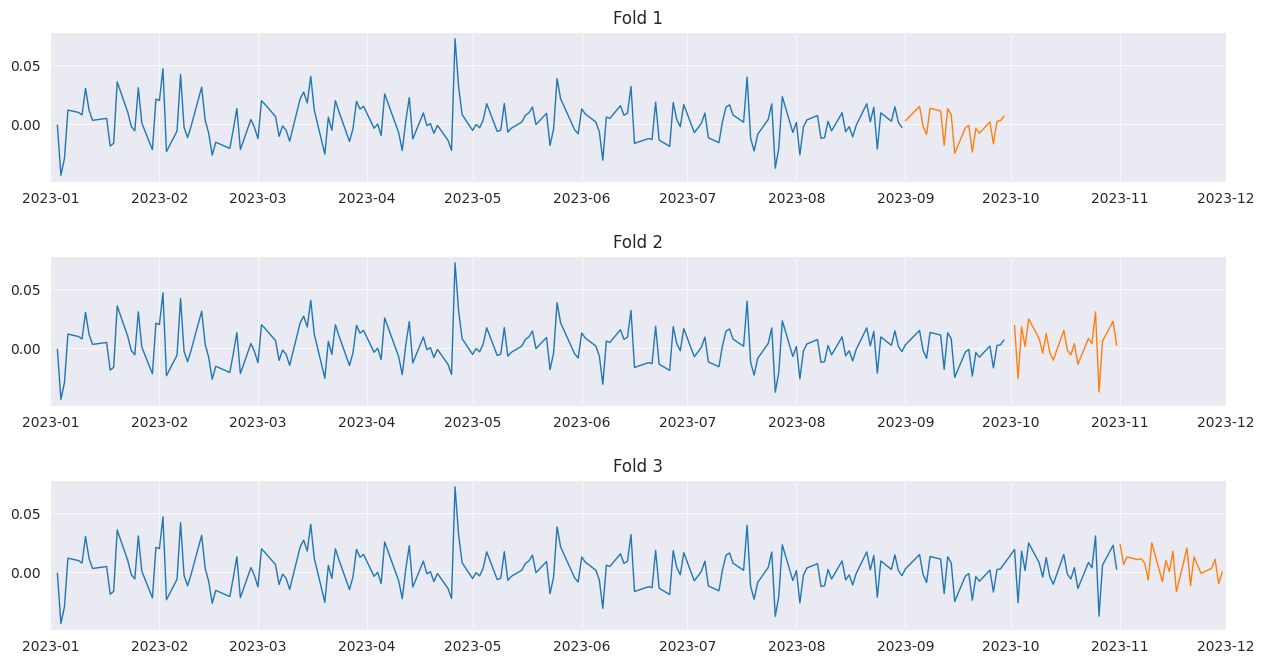

In [9]:
# visualize the 3 folds; cropped data before 2023 only for the visualization
plt.figure(figsize=(13, 7))
for i, kf in enumerate([fold1, fold2, fold3]):
    train = df['Return'].loc["2023":kf[0]]
    valid = df['Return'].loc[kf[1]]

    plt.subplot(3, 1, i+1)
    plt.plot(train, linewidth=1)
    plt.plot(valid, linewidth=1)
    plt.xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-12-01"))
    plt.title(f"Fold {i+1}")
    plt.grid(True, alpha=0.7)

plt.tight_layout(pad=2)
plt.show()

The choice of p and q parameters is obtained from the top 5 most significant lags from the partial autocorrelation and autocorrelation functions respectively.

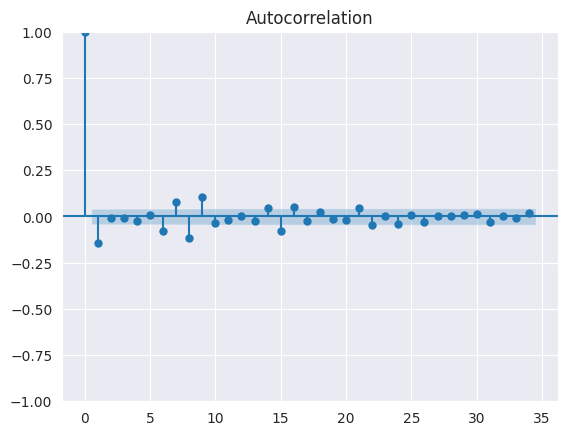

In [10]:
# get acf significance values and corresponding lags
acf_values = acf(train1, nlags=30)

# get the lags at 5% significance level
upper_confidence_interval = 1.96 / np.sqrt(len(train1))
significant_lags = np.where(np.abs(acf_values) > upper_confidence_interval)[0]
signif = [acf_values[x] for x in significant_lags]

# get top 5 significant lags
sig_tup = sorted([(x, abs(y)) for x, y in zip(significant_lags, signif)], key=lambda k: k[1], reverse=True)
sig_q = [k[0] for k in sig_tup[1:6]]

# plot acf
plot_acf(train1)
plt.show()

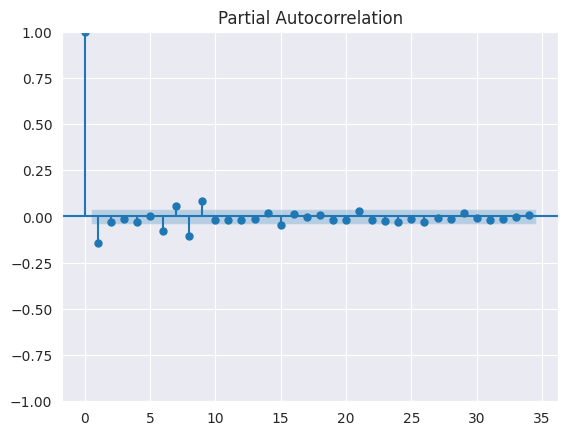

In [11]:
# get pacf significance values and corresponding lags
pacf_values = pacf(train1, nlags=30)

# get the lags at 5% significance level
upper_confidence_interval = 1.96 / np.sqrt(len(train1))
significant_lags = np.where(np.abs(pacf_values) > upper_confidence_interval)[0]
signif = [pacf_values[x] for x in significant_lags]

# get top 5 significant lags
sig_tup = sorted([(x, abs(y)) for x, y in zip(significant_lags, signif)], key=lambda k: k[1], reverse=True)
sig_p = [k[0] for k in sig_tup[1:6]]

# plot pacf
plot_pacf(train1)
plt.show()

In [ ]:
# check performance of ARMA with each combination of p & q
for p in sig_p:
    for q in sig_q:
        model_scores = []
        for kf in [fold1, fold2, fold3]:

            train = df['Return'].loc["2015":kf[0]]
            valid = df['Return'].loc[kf[1]]

            model = ARIMA(train, order=(p, 0, q))
            model_fit = model.fit()
            forecast = model_fit.forecast(len(valid))

            # mean absolute error as evaluation metric
            err = mean_absolute_error(valid.to_numpy(), forecast.to_numpy())
            model_scores.append(err)

        # average error across the 3 folds
        print(f"ARMA({p}, {q}): MAE = {np.mean(model_scores):.04f}")

ARMA(1, 1): MAE = 0.0108
ARMA(1, 8): MAE = 0.0109
ARMA(1, 9): MAE = 0.0108
ARMA(1, 7): MAE = 0.0109
ARMA(1, 6): MAE = 0.0109
ARMA(8, 1): MAE = 0.0107
ARMA(8, 8): MAE = 0.0109
ARMA(8, 9): MAE = 0.0109
ARMA(8, 7): MAE = 0.0104
ARMA(8, 6): MAE = 0.0109
ARMA(9, 1): MAE = 0.0107
ARMA(9, 8): MAE = 0.0108
ARMA(9, 9): MAE = 0.0107
ARMA(9, 7): MAE = 0.0109
ARMA(9, 6): MAE = 0.0107
ARMA(6, 1): MAE = 0.0107
ARMA(6, 8): MAE = 0.0109
ARMA(6, 9): MAE = 0.0108
ARMA(6, 7): MAE = 0.0108
ARMA(6, 6): MAE = 0.0108
ARMA(7, 1): MAE = 0.0107
ARMA(7, 8): MAE = 0.0109
ARMA(7, 9): MAE = 0.0109
ARMA(7, 7): MAE = 0.0108
ARMA(7, 6): MAE = 0.0109


Choosing the parameter combination that gives the least Mean Absolute Error (p=8, q=7).

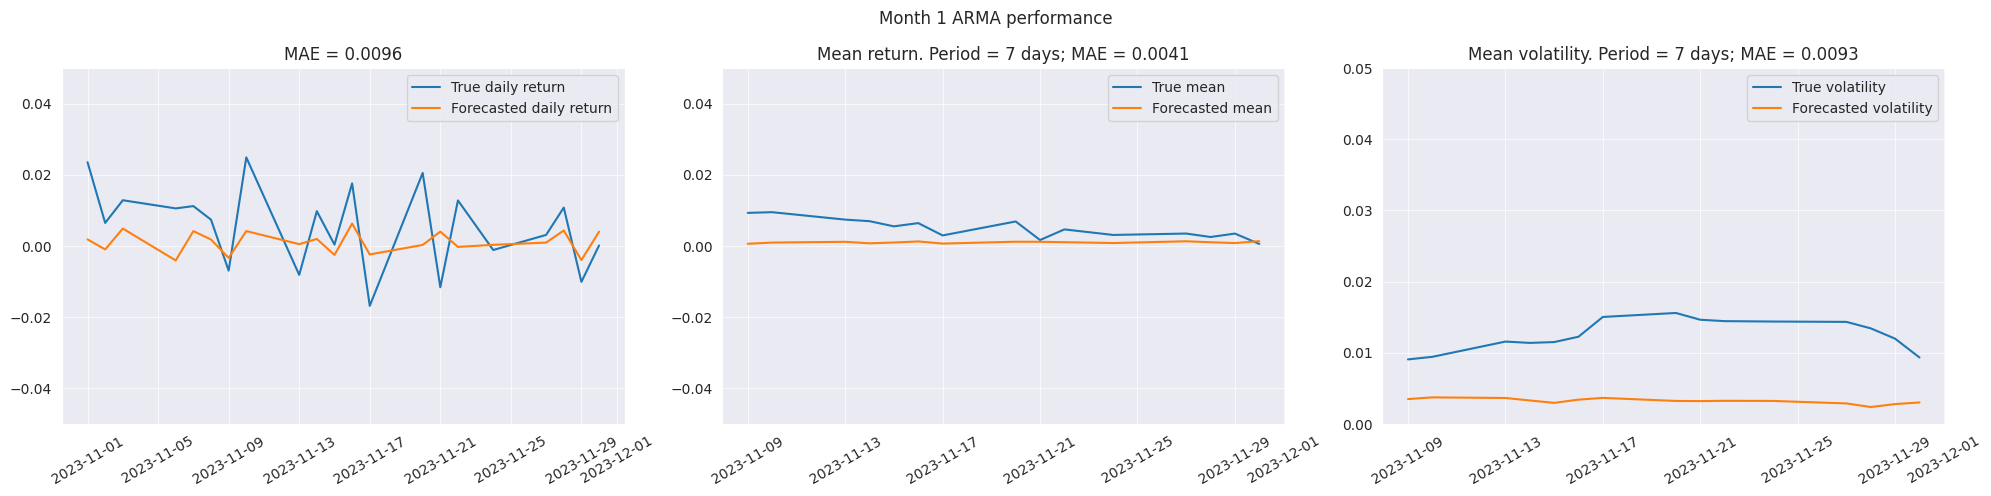

In [20]:
# short term performance on month 1
model = ARIMA(train1, order=(8, 0, 7))
model_fit = model.fit()
forecast1 = model_fit.forecast(len(test1))
plotter(forecast1, test1, "Month 1 ARMA")

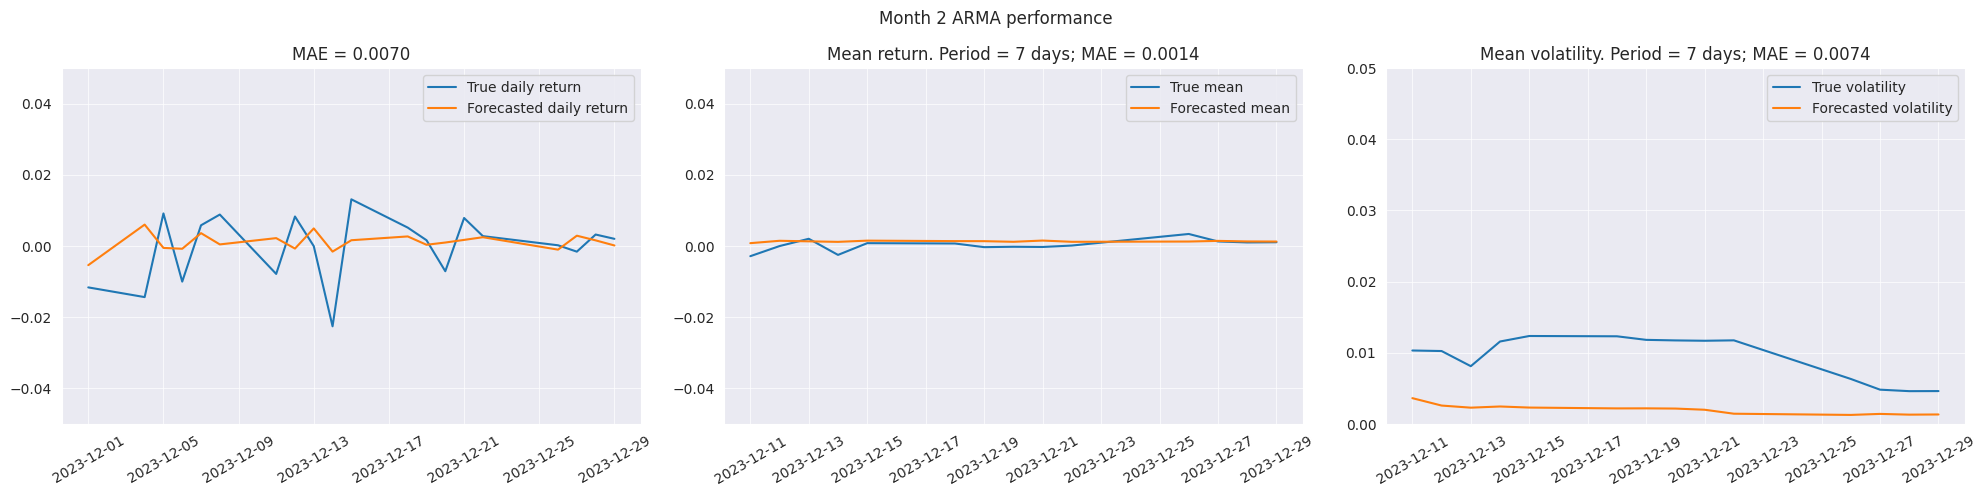

In [21]:
# short term performance on month 2
model = ARIMA(train2, order=(8, 0, 7))
model_fit = model.fit()
forecast2 = model_fit.forecast(len(test2))
plotter(forecast2, test2, "Month 2 ARMA")

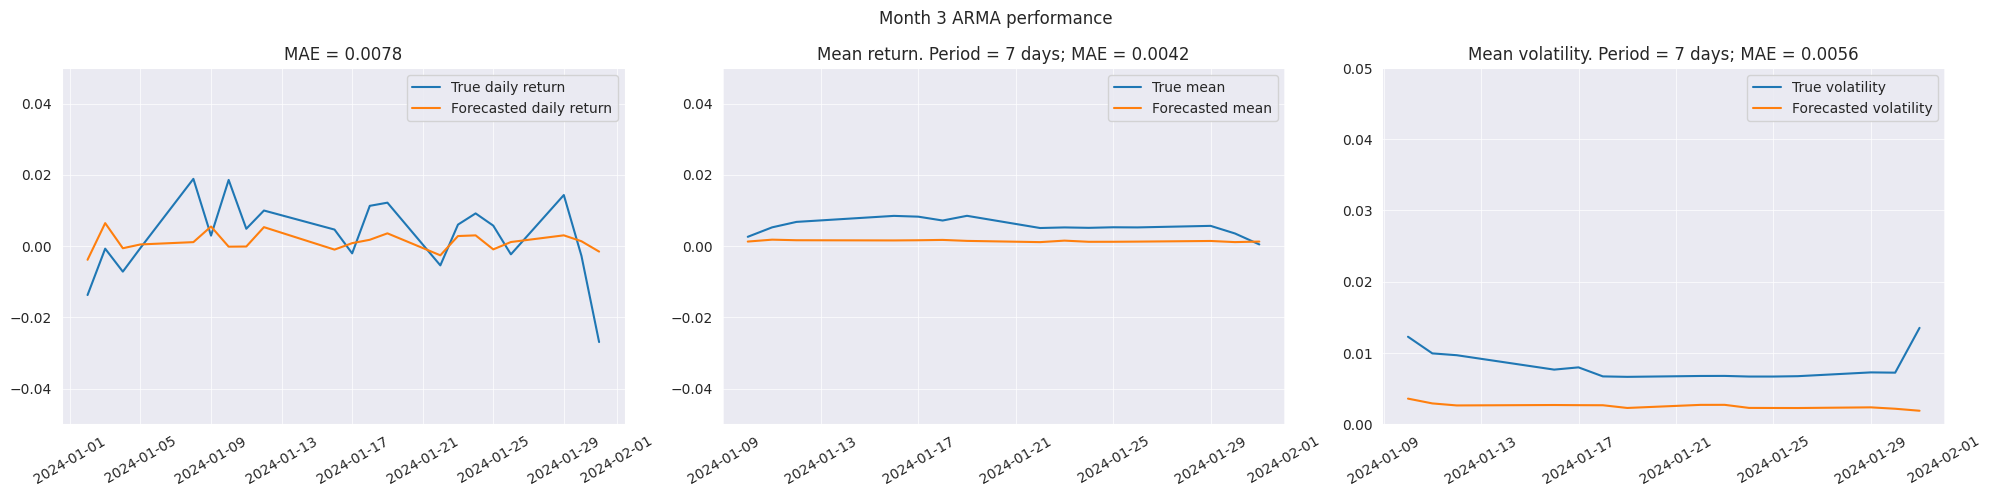

In [22]:
# short term performance on month 3
model = ARIMA(train3, order=(8, 0, 7))
model_fit = model.fit()
forecast3 = model_fit.forecast(len(test3))
plotter(forecast3, test3, "Month 3 ARMA")

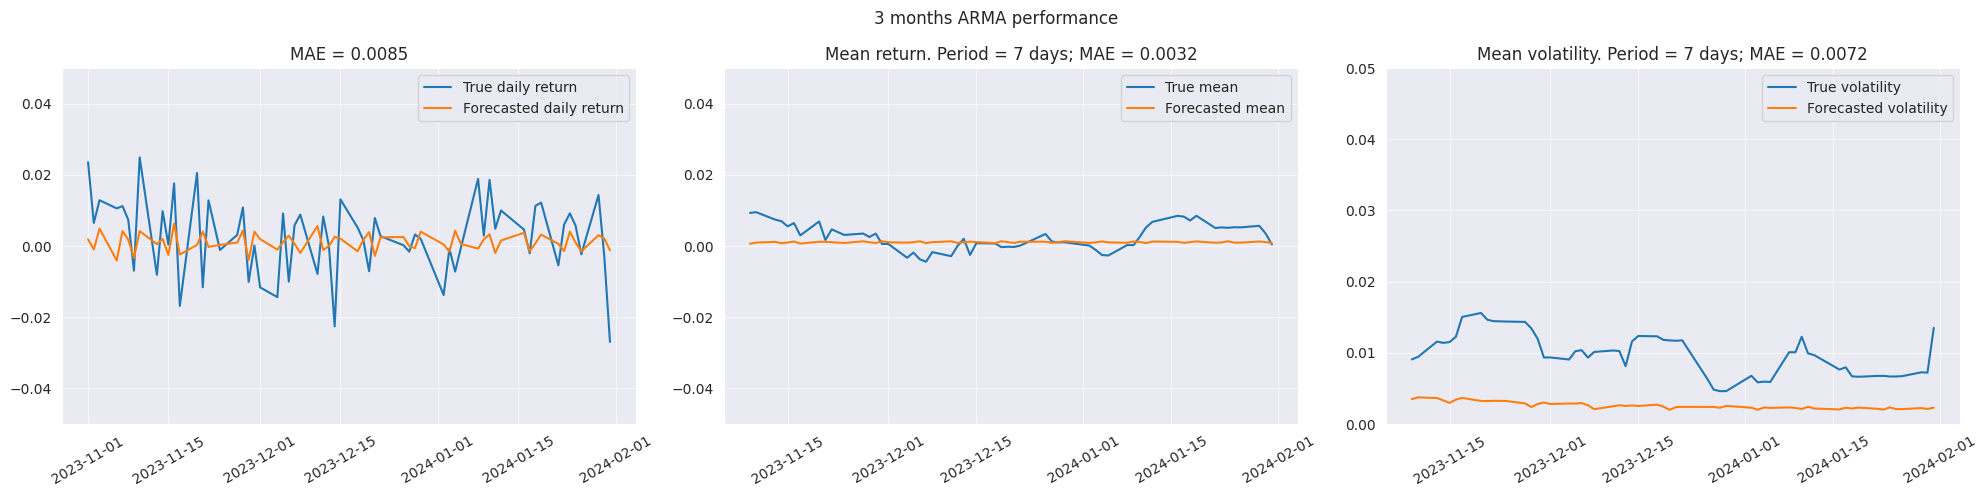

In [23]:
# long term performance on 3 months combined
model = ARIMA(train1, order=(8, 0, 7))
model_fit = model.fit()
forecast4 = model_fit.forecast(len(test_main))
plotter(forecast4, test_main, "3 months ARMA")

# Model - LSTM

In [24]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from statsmodels.tsa.stattools import pacf

In [25]:
# function to split series into X and Y with sliding window approach
def get_batches(data):

    X = []
    Y = []

    # condition to create sequence of window size as X and set immediate next value as Y
    for i in range(len(data)-window_size):
        x = data[i: i+window_size]
        y = data[i+window_size]

        # convert to tensors
        X.append(torch.tensor(x, dtype=torch.float32))
        Y.append(torch.tensor(y, dtype=torch.float32))

    # stack all tensors to generate batch dimension
    X = torch.stack(X)
    Y = torch.stack(Y)

    return X, Y

In [26]:
# function to estimate mean absolute error
# using the word 'loss' was a mistake caused by habit of using cross entropy loss :(


@torch.no_grad()
def print_losses(ep):

    model.eval()
    train_pred = model(X_train)
    valid_pred = model(X_valid)

    # cannot use sklearn's mean absolute error for backpropagation. L1Loss is its pytorch equivalent.
    loss_crit = torch.nn.L1Loss()
    train_loss = loss_crit(train_pred.squeeze(), Y_train)
    valid_loss = loss_crit(valid_pred.squeeze(), Y_valid)

    model.train()

    print(f"Epoch: {ep}\tTraining loss: {train_loss}\tValidation loss: {valid_loss}")

I'm not using cross validation for the deep learning model as there are other regularization methods.

In [27]:
# split data into train, validation and 3 test sets as before.
train = df['Return'].loc["2000":"2021"].dropna()
valid = df['Return'].loc["2022":"2023-10"]
test1 = df['Return'].loc["2023-11"]
test2 = df['Return'].loc["2023-12"]
test3 = df['Return'].loc["2024-01"]
test_main = df['Return'].loc["2023-11":"2024-01"]

This method involves splitting the original series into shorter sequences using a sliding window approach. The choice of sequence length was in assistance with the significant auto regressive lag given by the partial autocorrelation function.

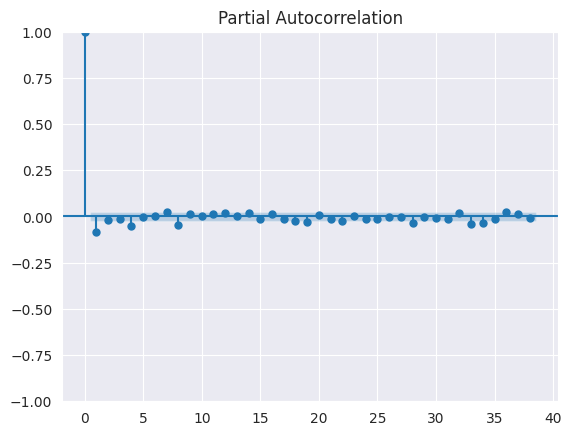

In [28]:
# get the significant lags from pacf for setting sequence length
pacf_values = pacf(train1, nlags=200)

upper_confidence_interval = 1.96 / np.sqrt(len(train))
significant_lags = np.where(np.abs(pacf_values) > upper_confidence_interval)[0]
signif = [pacf_values[x] for x in significant_lags]

sig_tup = sorted([(x, abs(y)) for x, y in zip(significant_lags, signif)], key=lambda k: k[1], reverse=True)
sig_step = [k[0] for k in sig_tup[1:21]]

plot_pacf(train)
plt.show()

In [ ]:
sig_step

[1,
 8,
 9,
 6,
 189,
 62,
 7,
 174,
 141,
 15,
 101,
 129,
 179,
 88,
 196,
 193,
 134,
 154,
 147,
 150]

The choice of window size was by by trial and error. Too short a window was unable to capture the complex patterns of the series while a too large window was causing the forecast of the initial data points to be way off in spite of doing well in the long term.

In [29]:
window_size = 174

As it is a sequence to sequence modelling, in order to forecast the initial data points in the tests, we need to augment [window_size] data from the series before it.

In [30]:
# convert series type data to numpy
train_data = train.to_numpy()
valid_data = valid.to_numpy()
test1_data = test1.to_numpy()
test2_data = test2.to_numpy()
test3_data = test3.to_numpy()
test_data = test_main.to_numpy()

# augment data to forecast initial data points
valid_data = np.concatenate((train_data[-window_size:], valid_data))
test1_data = np.concatenate((valid_data[-window_size:], test1_data))
test2_data = np.concatenate((np.concatenate((valid_data, test1_data))[-window_size:], test2_data))
test3_data = np.concatenate((np.concatenate((valid_data, test1_data, test2_data))[-window_size:], test3_data))
test_data = np.concatenate((valid_data[-window_size:], test_data))

In [31]:
# get x and y sets
X_train, Y_train = get_batches(train_data)
X_valid, Y_valid = get_batches(valid_data)
X_test1, Y_test1 = get_batches(test1_data)
X_test2, Y_test2 = get_batches(test2_data)
X_test3, Y_test3 = get_batches(test3_data)
Xm_test, Ym_test = get_batches(test_data)

In [32]:
# scale the datasests. Using robust scaler as it helps minimize the effects of outliers
scaler = RobustScaler()

# transform and convert back to tensor
X_train = torch.tensor(scaler.fit_transform(X_train.detach().numpy()), dtype=torch.float32)
X_valid = torch.tensor(scaler.transform(X_valid.detach().numpy()), dtype=torch.float32)
X_test1 = torch.tensor(scaler.transform(X_test1.detach().numpy()), dtype=torch.float32)
X_test2 = torch.tensor(scaler.transform(X_test2.detach().numpy()), dtype=torch.float32)
X_test3 = torch.tensor(scaler.transform(X_test3.detach().numpy()), dtype=torch.float32)
Xm_test = torch.tensor(scaler.transform(Xm_test.detach().numpy()), dtype=torch.float32)

The deep learning architecture I have used utilizes a multi layer perceptron block that transforms the sequential data before feeding into the LSTM. This approach was to emulate (in a simpler way) the application of Restricted Boltzmann Machines as suggested in this paper. Additionally, after the LSTM, instead of using a single fully connected layer to funnel the data to a single valued output, I have added an additional layer to add some more computation and make the network slightly deeper, to capture a bit more pattern in the series.

In [33]:
# Preprocessing input sequence before feeding into LSTM
class preproc(nn.Module):

    def __init__(self, input_n, output_n):
        super().__init__()

        # simple MLP block
        self.linear = nn.Linear(input_n, 64)
        self.hid = nn.Linear(64, output_n)
        self.dropout = nn.Dropout(0.2)

        # Layernorm before LSTM
        self.norm = nn.LayerNorm(normalized_shape=output_n)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.act(x)
        x = self.hid(x)
        x = self.norm(x)
        x = self.dropout(x)

        return x

In [34]:
class LSTMmodel(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers=2):
        super().__init__()

        self.preprocess = preproc(input_size, hidden_size1)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_size1, hidden_size2, num_layers, batch_first=True, dropout=0.2)

        # output funnel block
        self.fc1 = nn.Linear(hidden_size2, 4*hidden_size2)
        self.fc2 = nn.Linear(4*hidden_size2, 1)


    def forward(self, x):

        x = self.preprocess(x)
        out, _ = self.lstm(x)

        out = self.fc1(out)
        out = self.fc2(torch.tanh(out))

        return out

In [35]:
hidden_size1 = window_size
hidden_size2 = 32

In [36]:
torch.manual_seed(9)

model = LSTMmodel(window_size, hidden_size1, hidden_size2)

# weight decay parameter adds l2 reglarization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# training loop
for epoch in range(501):

    if epoch%100==0:
        print_losses(epoch)

    output = model(X_train)

    loss_crit = torch.nn.L1Loss()
    loss = loss_crit(output.squeeze(), Y_train)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Epoch: 0	Training loss: 0.05260411649942398	Validation loss: 0.05471113696694374
Epoch: 100	Training loss: 0.011540143750607967	Validation loss: 0.015465290285646915
Epoch: 200	Training loss: 0.007944459095597267	Validation loss: 0.016827670857310295
Epoch: 300	Training loss: 0.005230401176959276	Validation loss: 0.01788995787501335
Epoch: 400	Training loss: 0.003595132613554597	Validation loss: 0.018189657479524612
Epoch: 500	Training loss: 0.0031129640992730856	Validation loss: 0.018335629254579544


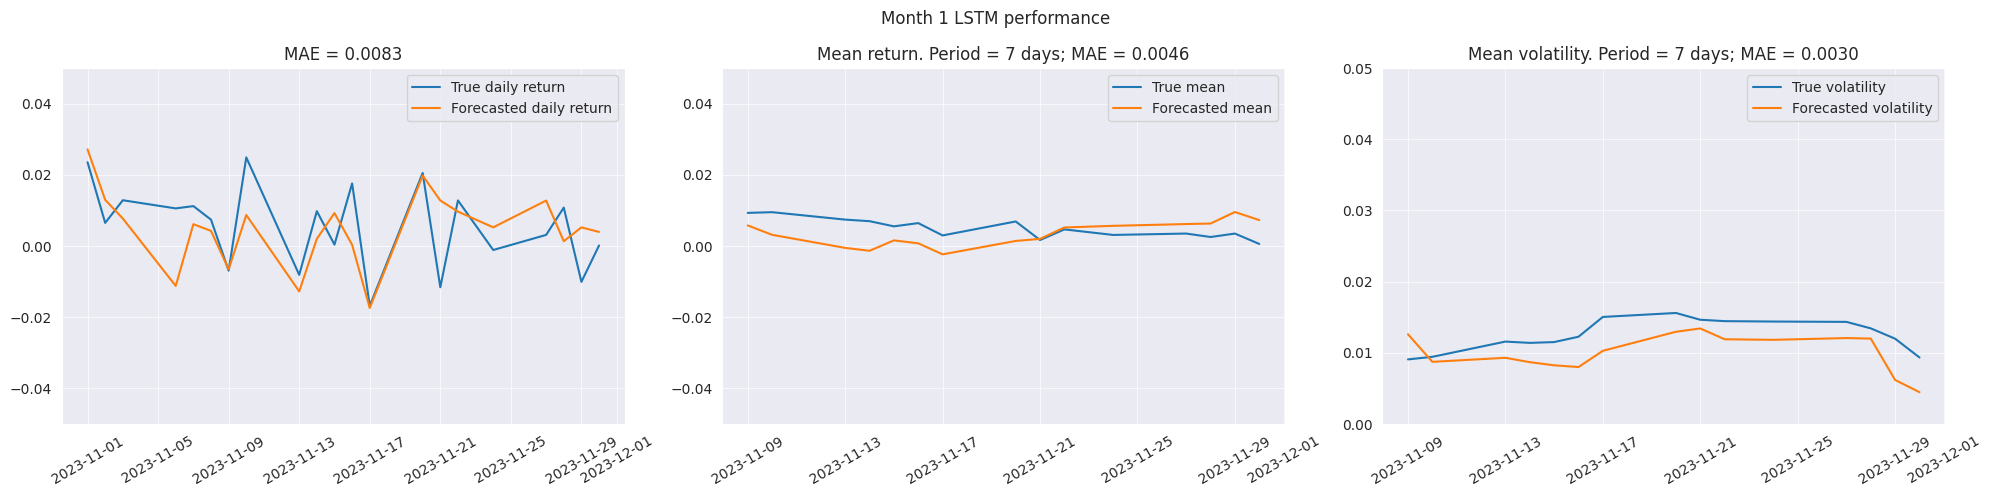

In [37]:
with torch.no_grad():
    model.eval()
    test_pred1 = model(X_test1)

test_pred1 = test_pred1.squeeze().detach().numpy()
plotter(test_pred1, test1, "Month 1 LSTM")

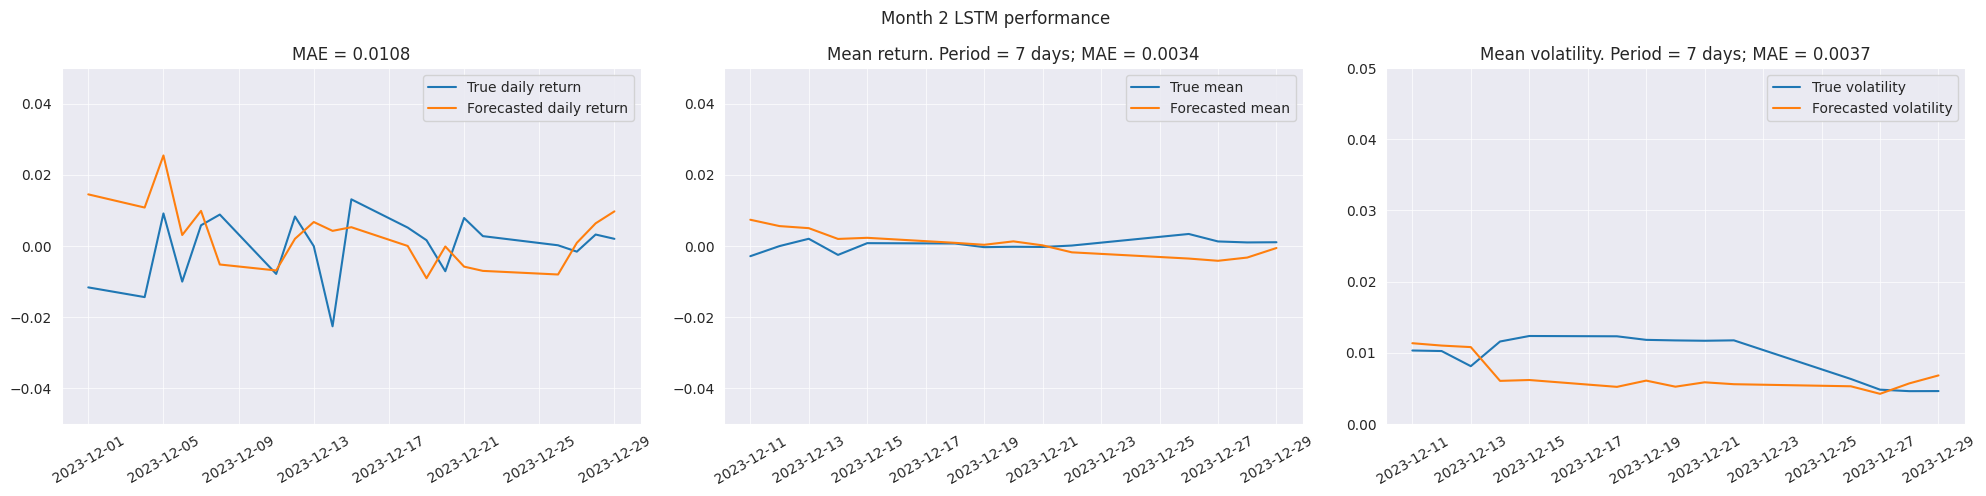

In [38]:
with torch.no_grad():
    model.eval()
    test_pred2 = model(X_test2)

test_pred2 = test_pred2.squeeze().detach().numpy()
plotter(test_pred2, test2, "Month 2 LSTM")

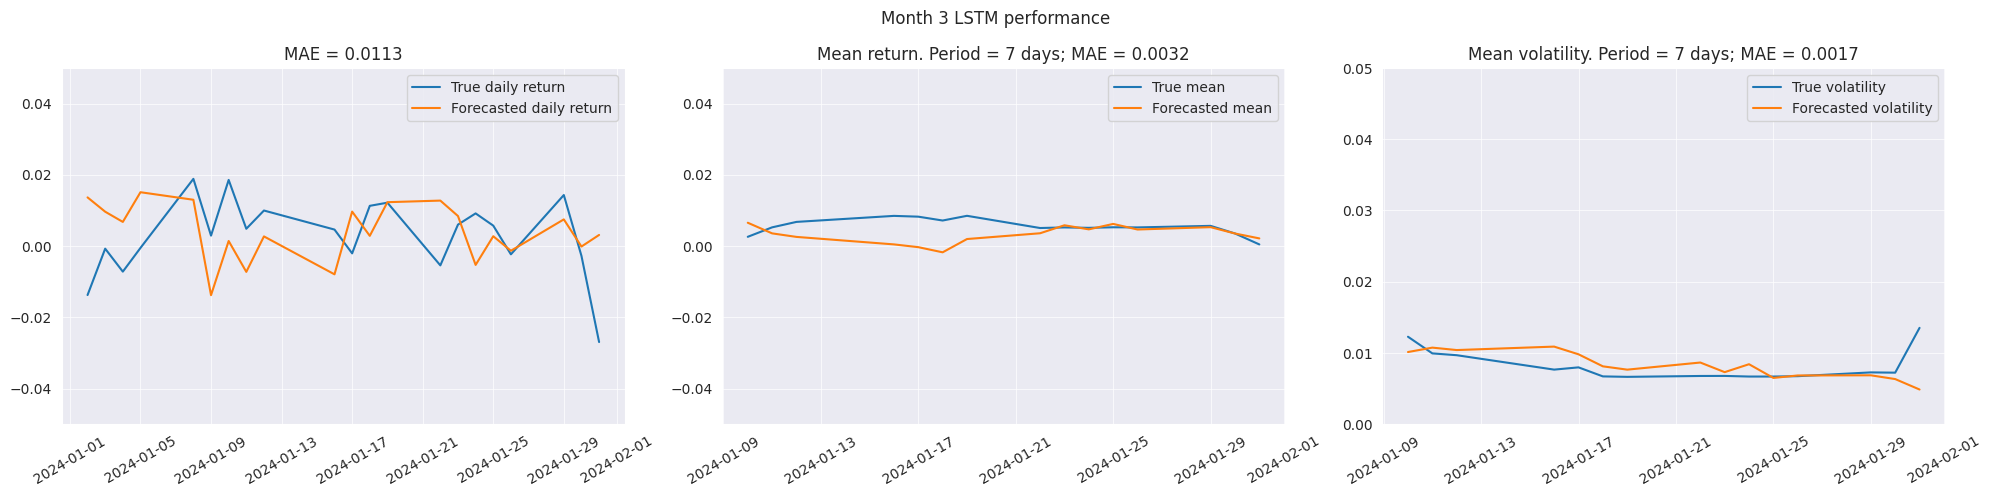

In [39]:
with torch.no_grad():
    model.eval()
    test_pred3 = model(X_test3)

test_pred3 = test_pred3.squeeze().detach().numpy()
plotter(test_pred3, test3, "Month 3 LSTM")

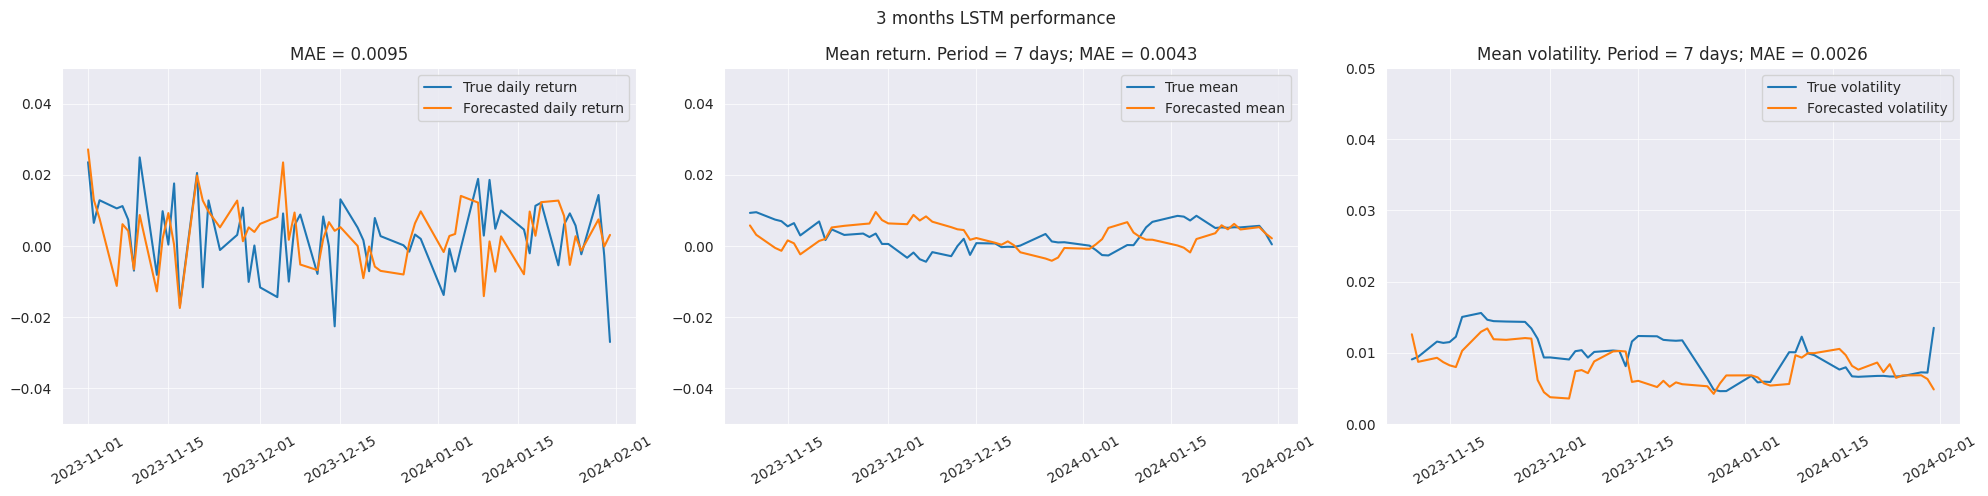

In [40]:
with torch.no_grad():
    model.eval()
    test_pred4 = model(Xm_test)

test_pred4 = test_pred4.squeeze().detach().numpy()
plotter(test_pred4, test_main, "3 months LSTM")

In [41]:
result_columns = []

for modl in ['MAE: ARMA', 'MAE: LSTM']:
    for forc in ['Return', 'Average', 'Volatility']:
        result_columns.append((modl, forc))


# Create column MultiIndex
mult_columns = pd.MultiIndex.from_tuples(result_columns)

# Data for the DataFrame
ma_errors = [
    [0.0096, 0.0041, 0.0093, 0.0083, 0.0046, 0.0030],
    [0.0070, 0.0014, 0.0074, 0.0108, 0.0034, 0.0037],
    [0.0078, 0.0042, 0.0056, 0.0113, 0.0032, 0.0017],
    [0.0085, 0.0032, 0.0072, 0.0095, 0.0043, 0.0026]
]

result_df = pd.DataFrame(ma_errors, columns=mult_columns, index=['Month 1', 'Month 2', 'Month 3', '3 months'])
result_df

MAE: ARMA                    MAE: LSTM                   
            Return Average Volatility    Return Average Volatility
Month 1     0.0096  0.0041     0.0093    0.0083  0.0046     0.0030
Month 2     0.0070  0.0014     0.0074    0.0108  0.0034     0.0037
Month 3     0.0078  0.0042     0.0056    0.0113  0.0032     0.0017
3 months    0.0085  0.0032     0.0072    0.0095  0.0043     0.0026

From the results, we can see that the ARMA model does better in forecasting the movement of daily returns themselves but does a bad job at capturing its extent (volatility). The LSTM also does fairly well in forecasting the movement of daily returns, although the ARMA does slightly better, the LSTM captures the volatility much better than the ARMA model.

In my opinion, LSTM gives a better output on the whole. If one is willing to trade off the daily returns accuracy a little bit to get a lot more regarding the market volatility.